###Mount Google Drive to the Colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Environment Setup and Library Installation


In [ ]:
!pip install np_utils
! pip install tensorflow
! pip install wfdb
! pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=f8f3b0ce3da8d51a74c03b247907ec74483671017cb081453c789b3ab18be71d
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00


###Importing Required Libraries

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, accuracy_score, recall_score
import pandas as pd
import wfdb
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from re import X
import pywt
from tqdm import tqdm
from scipy import stats
from wfdb import rdrecord, rdann
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AvgPool1D, Flatten, Dropout, Dense, Softmax,MaxPool1D
from tensorflow.keras import regularizers
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, accuracy_score, recall_score
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, MaxPooling1D, Activation, BatchNormalization, Lambda, TimeDistributed
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import save_model
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrixl

###functions

In [ ]:

def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

###Data Preparation and Preprocessing

In [ ]:

# Define constants for input size
input_size = 256


# Define the classes and their mappings
classes_MIT = ['N','V','/','A','F','L','R','f','j','E','a','J','Q','e','S','U']
classes = ['N','F','Q','S','V']

# List of record numbers to process
nums = [
    '100','101','102','104','105','106','107','108','109','111','112','113','114',
    '115','116','117','118','121','122','123','124','200','201','202','203','205',
    '207','208','209','210','212','213','214','215','217','219','220','221','222',
    '223','228','230','231','232','233','234'
]

# Features and excluded records
features = ['MLII', 'V1', 'V2', 'V4', 'V5']
outset = ['100', '103']

# Number of classes and their count initialization
n_classes = len(classes)
count_classes = [0] * n_classes

# Initialize lists for storing data and labels
X = list()
y = list()
y_signals0 = list()
x_signals0 = list()

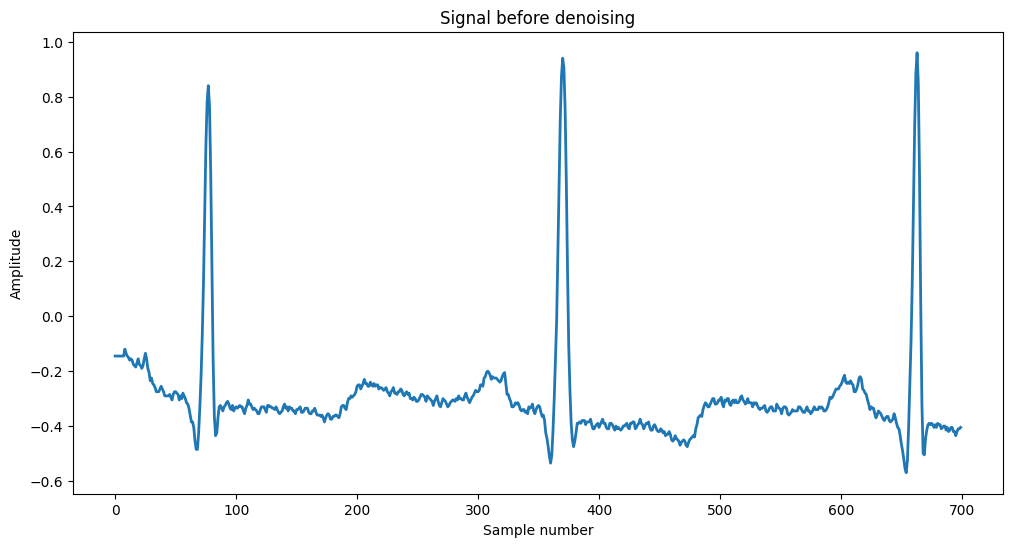

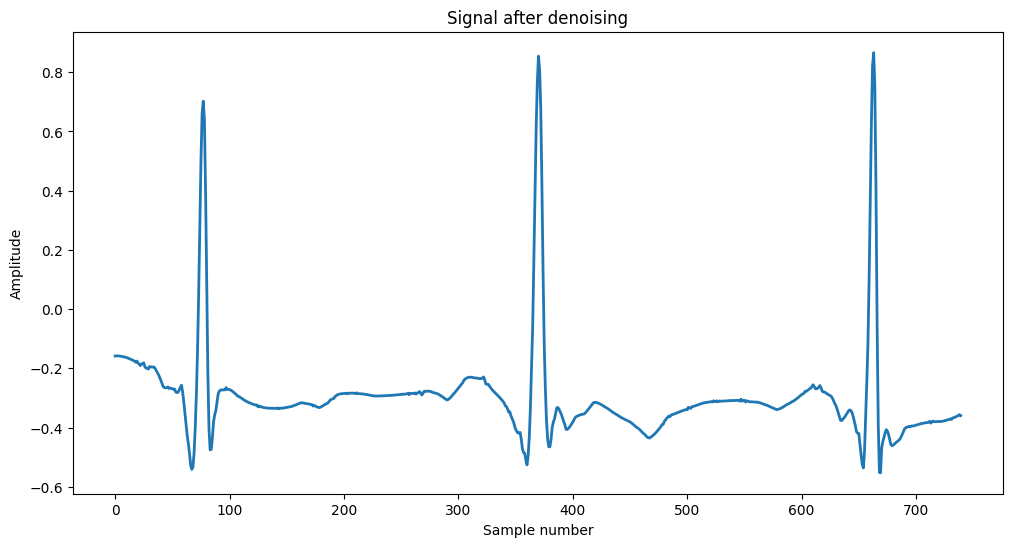

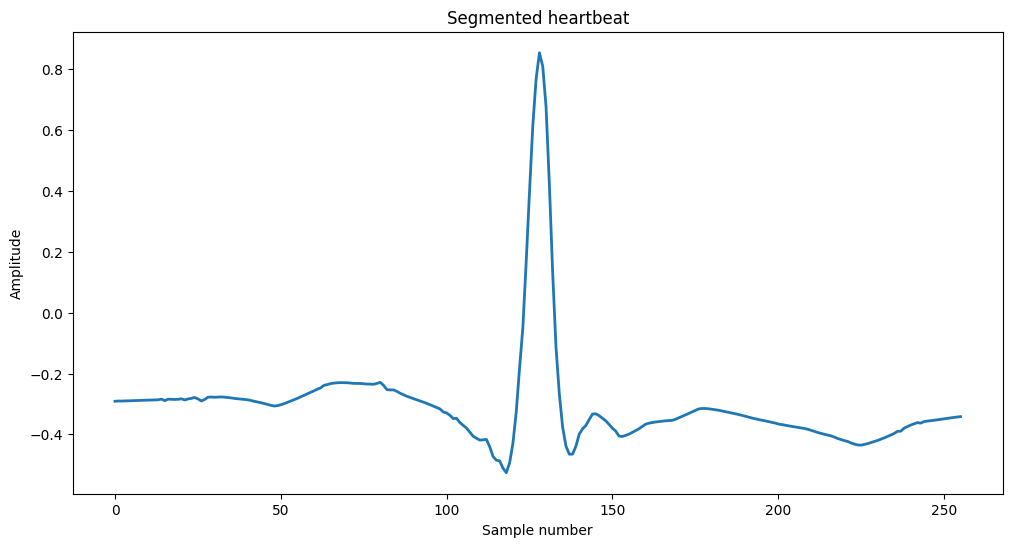

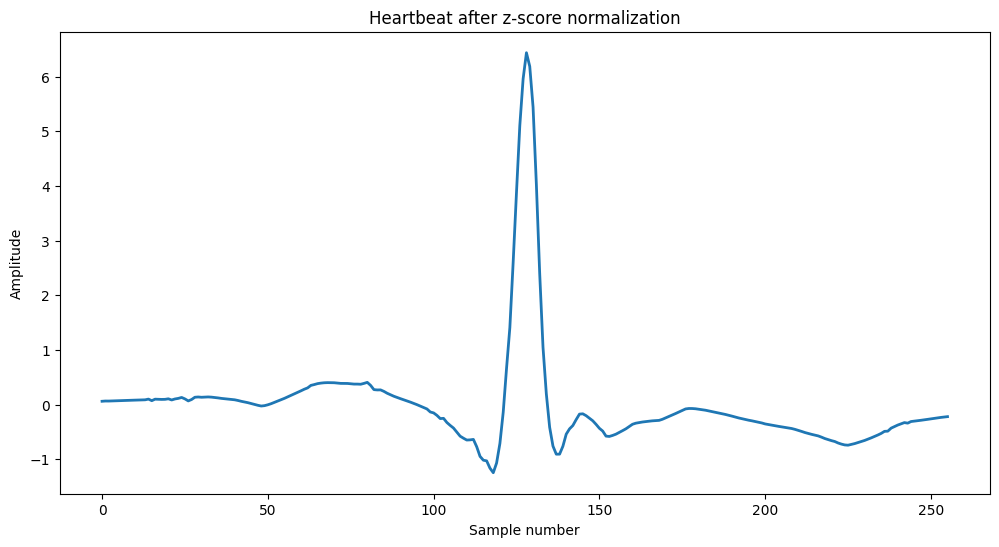

In [ ]:
# Iterate over each record number
for num in nums:
    # Read the record
    record = wfdb.rdrecord(
        '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/' + num,
        smooth_frames=True, channels=[0, 1]
    )

    # Check if the primary signal is 'MLII'
    if record.sig_name[0] != 'MLII':
        continue

    # Get the signal and replace NaNs with 0
    signals0 = np.nan_to_num(record.p_signal[:, 0]).tolist()

    # Plot the original signal for record "100"
    if num == "100":
        plt.figure(figsize=(12, 6))
        plt.ylabel('Amplitude')
        plt.xlabel('Sample number')
        plt.title("Signal before denoising")
        plt.plot(signals0[0:700], linewidth=2)
        plt.show()

    # Denoise the signal
    signals0 = denoise(signals0)

    # Plot the denoised signal for record "100"
    if num == "100":
        plt.figure(figsize=(12, 6))
        plt.title("Signal after denoising")
        plt.plot(signals0[0:740], linewidth=2)
        plt.ylabel('Amplitude')
        plt.xlabel('Sample number')
        plt.show()

    # Find peaks in the denoised signal
    peaks_signals0, _ = find_peaks(signals0, distance=150)

    # Initialize flags for example heartbeat plots
    example_beat_printed = False
    example_beat_normalized_printed = False

    # Iterate over the detected peaks
    for peak in peaks_signals0[1:-1]:
        start, end = peak - 128, peak + 128
        ann = wfdb.rdann(
            "/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/" + num,
            extension='atr', sampfrom=start, sampto=end
        )
        annSymbol = ann.symbol
        wave = signals0[start:end]

        # Plot an example heartbeat segment
        if num == "100" and not example_beat_printed:
            plt.figure(figsize=(12, 6))
            plt.title("Segmented heartbeat")
            plt.ylabel('Amplitude')
            plt.xlabel('Sample number')
            plt.plot(wave, linewidth=2)
            plt.show()
            example_beat_printed = True

        # Normalize the wave using z-score
        wave = stats.zscore(wave)

        # Plot the normalized heartbeat segment
        if num == "100" and not example_beat_normalized_printed:
            plt.figure(figsize=(12, 6))
            plt.ylabel('Amplitude')
            plt.xlabel('Sample number')
            plt.title("Heartbeat after z-score normalization")
            plt.plot(wave, linewidth=2)
            plt.show()
            example_beat_normalized_printed = True

        # Classify the heartbeat based on annotation
        if len(annSymbol) == 1 and (annSymbol[0] in classes_MIT):
            if annSymbol[0] == 'F':
                arrhythmia_index = classes.index('F')
            elif annSymbol[0] in ['N', 'L', 'R', 'e', 'j']:
                arrhythmia_index = classes.index('N')
            elif annSymbol[0] in ['/', 'f', 'U']:
                arrhythmia_index = classes.index('Q')
            elif annSymbol[0] in ['A', 'a', 'J', 'S']:
                arrhythmia_index = classes.index('S')
            elif annSymbol[0] in ['V', 'E']:
                arrhythmia_index = classes.index('V')

            count_classes[arrhythmia_index] += 1
            x_signals0.append(wave)
            y_signals0.append(arrhythmia_index)

###Data Storage

In [ ]:
# Create a DataFrame from lists
df = pd.DataFrame({'x_signals0': x_signals0, 'y_signals0': y_signals0})

# Convert DataFrame columns to NumPy arrays
x_signals0_array = df['x_signals0'].to_numpy()
y_signals0_array = df['y_signals0'].to_numpy()

# Save numpy arrays
np.save('/content/drive/MyDrive/x_signals_256.npy', x_signals0_array)
np.save('/content/drive/MyDrive/y_signals_256.npy', y_signals0_array)


###Data Loading

In [ ]:
# Load X from file with allow_pickle=True
X = np.load('/content/drive/MyDrive/x_signals_256.npy', allow_pickle=True)

# Find the maximum length of arrays along the second axis
max_length = max(len(x) for x in X)


X = np.array([np.concatenate((x, np.zeros(max_length - len(x)))) if len(x) < max_length else x[:max_length] for x in X])

# Stack nested arrays vertically
X = np.vstack(X)

# Load y from file with allow_pickle=True
y = np.load('/content/drive/MyDrive/y_signals_256.npy', allow_pickle=True)


###Data Splitting and Class Distribution

In [ ]:
# Calculate the count of each class
class_counts = [np.sum(y == i) for i in range(5)]

# Print the count of each class
for i, count in enumerate(class_counts):
    print(f"Class {i} has {count} samples")

Class 0 has 87980 samples
Class 1 has 779 samples
Class 2 has 3859 samples
Class 3 has 2435 samples
Class 4 has 6705 samples


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
# Calculate the count of each class
class_counts = [np.sum(train_y == i) for i in range(5)]

# Print the count of each class
for i, count in enumerate(class_counts):
    print(f"Class {i} has {count} samples")

Class 0 has 70384 samples
Class 1 has 623 samples
Class 2 has 3087 samples
Class 3 has 1948 samples
Class 4 has 5364 samples


In [ ]:
# Calculate the count of each class
class_counts = [np.sum(test_y == i) for i in range(5)]

# Print the count of each class
for i, count in enumerate(class_counts):
    print(f"Class {i} has {count} samples")

Class 0 has 17596 samples
Class 1 has 156 samples
Class 2 has 772 samples
Class 3 has 487 samples
Class 4 has 1341 samples


###ECG Model Definition

In [ ]:


def zeropad(x):
    y = K.zeros_like(x)
    return K.concatenate([x, y], axis=2)

def zeropad_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3
    shape[2] *= 2
    return tuple(shape)

def ECG_model():


    model = Sequential()

    # First convolutional block
    model.add(Conv1D(filters=32, kernel_size=16, padding='same', kernel_initializer='he_normal', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=1, strides=1))

    model.add(Conv1D(filters=32, kernel_size=16, padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=32, kernel_size=16, padding='same', kernel_initializer='he_normal'))

    # Main loop blocks
    filter_length = 32
    n_blocks = 15
    for block_index in range(n_blocks):
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D(filters=filter_length, kernel_size=16, padding='same', kernel_initializer='he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Conv1D(filters=filter_length, kernel_size=16, padding='same', kernel_initializer='he_normal'))
        if block_index % 2 == 0:
            model.add(MaxPooling1D(pool_size=2))
        if block_index % 4 == 0 and block_index > 0:
            model.add(Lambda(zeropad, output_shape=zeropad_output_shape))
            filter_length *= 2

    # Output block
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax'))




    model.summary()
    return model




###Cross-Validation Training

In [ ]:



initial_epoch = 0
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize list to store history for each fold
histories = []

# Iterate over folds
for fold_index, (train_index, test_index) in enumerate(kf.split(train_x)):
    print(f"Fold {fold_index + 1}/{n_splits}")

    # Create train and test sets for this fold
    fold_train_x, fold_val_x = train_x[train_index], train_x[test_index]
    fold_train_y, fold_val_y = train_y[train_index], train_y[test_index]
    from imblearn.over_sampling import RandomOverSampler

# Oversample the training data
    oversampler = RandomOverSampler(random_state=42)
    fold_train_x_resampled, fold_train_y_resampled = oversampler.fit_resample(fold_train_x, fold_train_y)


    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        TensorBoard(log_dir=f'./logs/fold_{fold_index}', histogram_freq=0, write_graph=True, write_grads=False, write_images=True),
        ModelCheckpoint(f'/content/drive/MyDrive/MLII-latest_v1_fold_{fold_index}.hdf5', monitor='val_loss', save_best_only=False, verbose=1, period=10)

    ]


    model = ECG_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    history = model.fit(fold_train_x_resampled, to_categorical(fold_train_y_resampled),
                        validation_data=(fold_val_x, to_categorical(fold_val_y)),
                        epochs=30,
                        batch_size=185,
                        callbacks=callbacks,
                        initial_epoch=initial_epoch)

    # Append the history for this fold to the list
    histories.append(history)


Fold 1/5


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 256, 32)           544       
                                                                 
 batch_normalization_66 (Ba  (None, 256, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_66 (Activation)  (None, 256, 32)           0         
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_67 (Conv1D)          (None, 256, 32)           16416     
                                                                 
 batch_normalization_67 (Ba  (None, 256, 32)          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1522/1522 [==============================] - 86s 57ms/step - loss: 0.0453 - accuracy: 0.9862 - val_loss: 0.0812 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 11/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0400 - accuracy: 0.9882 - val_loss: 0.1092 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 12/30
1522/1522 [==============================] - 85s 56ms/step - loss: 0.0351 - accuracy: 0.9894 - val_loss: 0.0941 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 13/30
1522/1522 [==============================] - 85s 56ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.0899 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 14/30
1522/1522 [==============================] - 85s 56ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.0798 - val_accuracy: 0.9785 - lr: 0.0010
Epoch 15/30
1522/1522 [==============================] - 85s 56ms/step - loss: 0.0280 - accuracy: 0.9919 - val_loss: 0.1839 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 16/30
1522/1522 [=============================

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_99 (Conv1D)          (None, 256, 32)           544       
                                                                 
 batch_normalization_99 (Ba  (None, 256, 32)           128       
 tchNormalization)                                               
                                                                 
 activation_99 (Activation)  (None, 256, 32)           0         
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_100 (Conv1D)         (None, 256, 32)           16416     
                                                                 
 batch_normalization_100 (B  (None, 256, 32)          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1523/1523 [==============================] - 87s 57ms/step - loss: 0.0444 - accuracy: 0.9867 - val_loss: 0.1214 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 11/30
1523/1523 [==============================] - 86s 57ms/step - loss: 0.0392 - accuracy: 0.9882 - val_loss: 0.0860 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 12/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0339 - accuracy: 0.9897 - val_loss: 0.0948 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 13/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0323 - accuracy: 0.9904 - val_loss: 0.0811 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 14/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0309 - accuracy: 0.9908 - val_loss: 0.0995 - val_accuracy: 0.9722 - lr: 0.0010
Epoch 15/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0849 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 16/30
1523/1523 [=============================

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_132 (Conv1D)         (None, 256, 32)           544       
                                                                 
 batch_normalization_132 (B  (None, 256, 32)           128       
 atchNormalization)                                              
                                                                 
 activation_132 (Activation  (None, 256, 32)           0         
 )                                                               
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_133 (Conv1D)         (None, 256, 32)           16416     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1525/1525 [==============================] - 87s 57ms/step - loss: 0.0473 - accuracy: 0.9855 - val_loss: 0.1896 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 11/30
1525/1525 [==============================] - 86s 57ms/step - loss: 0.0391 - accuracy: 0.9882 - val_loss: 0.1324 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 12/30
1525/1525 [==============================] - 86s 56ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.0754 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 13/30
1525/1525 [==============================] - 86s 56ms/step - loss: 0.0338 - accuracy: 0.9897 - val_loss: 0.1055 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 14/30
1525/1525 [==============================] - 86s 56ms/step - loss: 0.0309 - accuracy: 0.9906 - val_loss: 0.0895 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 15/30
1525/1525 [==============================] - 86s 56ms/step - loss: 0.0283 - accuracy: 0.9916 - val_loss: 0.0629 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 16/30
1525/1525 [=============================

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_165 (Conv1D)         (None, 256, 32)           544       
                                                                 
 batch_normalization_165 (B  (None, 256, 32)           128       
 atchNormalization)                                              
                                                                 
 activation_165 (Activation  (None, 256, 32)           0         
 )                                                               
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_166 (Conv1D)         (None, 256, 32)           16416     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1522/1522 [==============================] - 87s 57ms/step - loss: 0.0448 - accuracy: 0.9863 - val_loss: 0.0896 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 11/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0972 - val_accuracy: 0.9732 - lr: 0.0010
Epoch 12/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0387 - accuracy: 0.9884 - val_loss: 0.1038 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 13/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0310 - accuracy: 0.9907 - val_loss: 0.0907 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 14/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0319 - accuracy: 0.9905 - val_loss: 0.0940 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 15/30
1522/1522 [==============================] - 86s 56ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.1048 - val_accuracy: 0.9690 - lr: 0.0010
Epoch 16/30
1522/1522 [=============================

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_198 (Conv1D)         (None, 256, 32)           544       
                                                                 
 batch_normalization_198 (B  (None, 256, 32)           128       
 atchNormalization)                                              
                                                                 
 activation_198 (Activation  (None, 256, 32)           0         
 )                                                               
                                                                 
 max_pooling1d_54 (MaxPooli  (None, 256, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_199 (Conv1D)         (None, 256, 32)           16416     
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1523/1523 [==============================] - 87s 57ms/step - loss: 0.0454 - accuracy: 0.9864 - val_loss: 0.1037 - val_accuracy: 0.9711 - lr: 0.0010
Epoch 11/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.1371 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 12/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.1159 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 13/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.1204 - val_accuracy: 0.9664 - lr: 0.0010
Epoch 14/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0299 - accuracy: 0.9911 - val_loss: 0.1220 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 15/30
1523/1523 [==============================] - 86s 56ms/step - loss: 0.0297 - accuracy: 0.9912 - val_loss: 0.1230 - val_accuracy: 0.9657 - lr: 0.0010
Epoch 16/30
1523/1523 [=============================

###Saving Trained Models and  Validation Performance

In [ ]:


# Iterate over the histories
for fold_index, history in enumerate(histories):
    print(f"Fold {fold_index + 1}")

    # Extract validation accuracy for this fold from the history
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {val_accuracy}")

    # Access the trained model from history
    model = history.model

    # Save the model to a file
    model_file_path = f'/content/drive/MyDrive/MLII-model_fold_{fold_index}.h5'
    model.save(model_file_path)
    print(f"Model saved to: {model_file_path}")


Fold 1
Validation Accuracy: 0.9839085936546326
Model saved to: /content/drive/MyDrive/MLII-model_fold_0.h5
Fold 2
Validation Accuracy: 0.9840918779373169
Model saved to: /content/drive/MyDrive/MLII-model_fold_1.h5
Fold 3
Validation Accuracy: 0.9859959483146667
Model saved to: /content/drive/MyDrive/MLII-model_fold_2.h5
Fold 4
Validation Accuracy: 0.9825563430786133
Model saved to: /content/drive/MyDrive/MLII-model_fold_3.h5
Fold 5
Validation Accuracy: 0.978809654712677
Model saved to: /content/drive/MyDrive/MLII-model_fold_4.h5


###Loss and Accuracy Curve

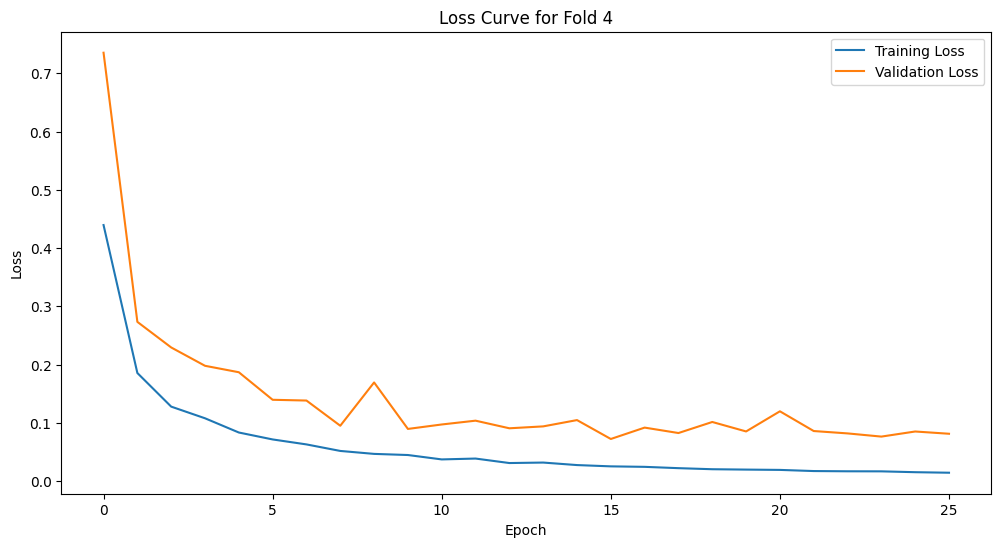

In [ ]:


# Extract the history for the third fold
fold_history = histories[3]
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(fold_history.history['loss'], label='Training Loss')
plt.plot(fold_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve for Fold 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




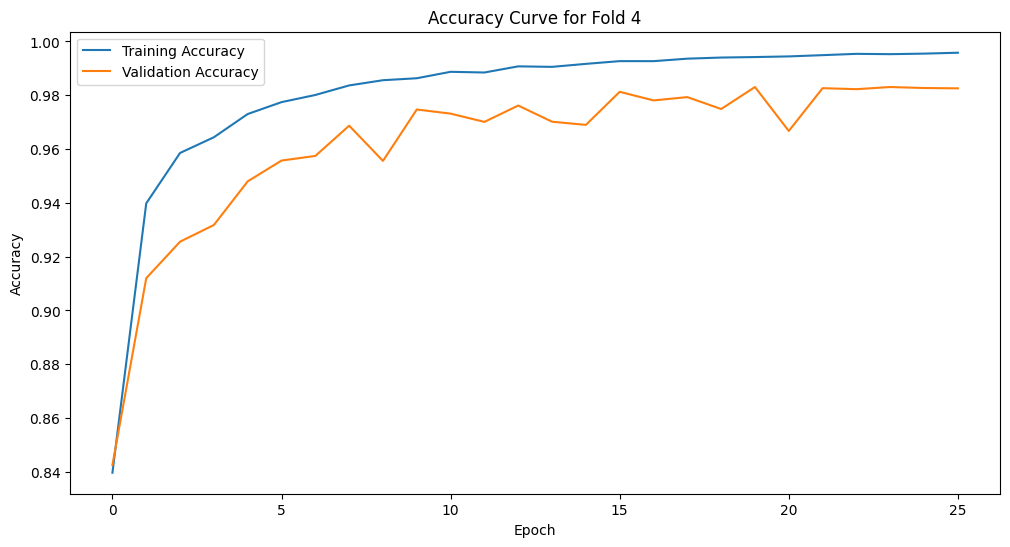

In [ ]:
# Plot accuracy curve
plt.figure(figsize=(12, 6))
plt.plot(fold_history.history['accuracy'], label='Training Accuracy')
plt.plot(fold_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve for Fold 4')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### confusion matrix

636/636 [==============================] - 21s 32ms/step


Text(170.72222222222223, 0.5, 'True Label')

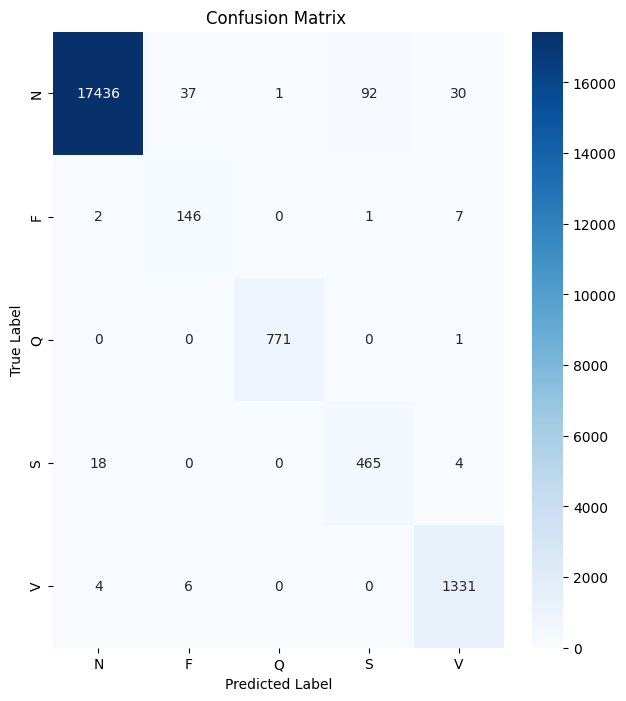

In [ ]:

K.set_image_data_format('channels_last')
# Extract the model from the third fold's history
model = load_model("/content/drive/MyDrive/MLII-model_fold_3.h5")

test_predictions = model.predict(test_x)
test_predictions = np.argmax(test_predictions, axis=1)
# Compute confusion matrix
conf_matrix = confusion_matrix(test_y, test_predictions)
# Calculate confusion matrix with percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot both confusion matrices
plt.figure(figsize=(16, 8))

# Plot confusion matrix with counts
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix ')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')



###Evaluating Model Performance Across Folds

In [ ]:



# Define lists to store metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
class_accuracy_list = []
class_f1_list = []
class_precision_list = []
class_recall_list = []

# Iterate through each fold
for fold_index in range(5):  # Assuming you have 5 folds
    print(f"Fold {fold_index}:")
    # Load the model for the current fold
    model_path = f"/content/drive/MyDrive/MLII-model_fold_{fold_index}.h5"
    model = load_model(model_path)

    # Make predictions on the test set
    test_predictions = model.predict(test_x)
    test_predictions = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_y, test_predictions)

    # Calculate accuracy
    accuracy = accuracy_score(test_y, test_predictions)
    accuracy_scores.append(accuracy)

    # Calculate F1 score
    f1 = f1_score(test_y, test_predictions, average='weighted')
    f1_scores.append(f1)

    # Calculate precision
    precision = precision_score(test_y, test_predictions, average='weighted')
    precision_scores.append(precision)

    # Calculate recall
    recall = recall_score(test_y, test_predictions, average='weighted')
    recall_scores.append(recall)

    # Calculate accuracy, F1 score, precision, and recall for each class
    class_accuracy = {}
    class_f1 = {}
    class_precision = {}
    class_recall = {}
    for i, class_name in enumerate(classes):
        true_positives = conf_matrix[i, i]
        false_positives = np.sum(conf_matrix[:, i]) - true_positives
        false_negatives = np.sum(conf_matrix[i, :]) - true_positives
        true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

        class_accuracy[class_name] = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
        class_f1[class_name] = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
        class_precision[class_name] = true_positives / (true_positives + false_positives)
        class_recall[class_name] = true_positives / (true_positives + false_negatives)

    class_accuracy_list.append(class_accuracy)
    class_f1_list.append(class_f1)
    class_precision_list.append(class_precision)
    class_recall_list.append(class_recall)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Class-wise Accuracy:", class_accuracy)
    print("Class-wise F1 Score:", class_f1)
    print("Class-wise Precision:", class_precision)
    print("Class-wise Recall:", class_recall)
    print()

# Calculate average accuracy, F1 score, precision, and recall across all folds
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print("Average Accuracy:", average_accuracy)
print("Average F1 Score:", average_f1)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

# Calculate average class-wise accuracy, F1 score, precision, and recall across all folds
average_class_accuracy = {}
average_class_f1 = {}
average_class_precision = {}
average_class_recall = {}

for class_name in classes:
    class_acc = [class_acc[class_name] for class_acc in class_accuracy_list]
    class_f1s = [class_f1[class_name] for class_f1 in class_f1_list]
    class_precisions = [class_precision[class_name] for class_precision in class_precision_list]
    class_recalls = [class_recall[class_name] for class_recall in class_recall_list]

    average_class_accuracy[class_name] = np.mean(class_acc)
    average_class_f1[class_name] = np.mean(class_f1s)
    average_class_precision[class_name] = np.mean(class_precisions)
    average_class_recall[class_name] = np.mean(class_recalls)

print("\nAverage Class-wise Accuracy:")
for class_name, acc in average_class_accuracy.items():
    print(f"{class_name}: {acc}")

print("\nAverage Class-wise F1 Score:")
for class_name, f1_score in average_class_f1.items():
    print(f"{class_name}: {f1_score}")

print("\nAverage Class-wise Precision:")
for class_name, precision in average_class_precision.items():
    print(f"{class_name}: {precision}")

print("\nAverage Class-wise Recall:")
for class_name, recall in average_class_recall.items():
    print(f"{class_name}: {recall}")


Fold 0:
636/636 [==============================] - 7s 7ms/step
Accuracy: 0.9849646226415094
F1 Score: 0.9853780921886371
Precision: 0.9860709977767423
Recall: 0.9849646226415094
Class-wise Accuracy: {'N': 0.9862912735849056, 'F': 0.9957252358490566, 'Q': 0.9999508647798742, 'S': 0.9926297169811321, 'V': 0.9953321540880503}
Class-wise F1 Score: {'N': 0.9920378984618019, 'F': 0.7692307692307693, 'Q': 0.9993913572732805, 'S': 0.85, 'V': 0.9640559969731366}
Class-wise Precision: {'N': 0.9947916666666666, 'F': 0.6904761904761905, 'Q': 1.0, 'S': 0.8095238095238095, 'V': 0.9622356495468278}
Class-wise Recall: {'N': 0.9892993340543002, 'F': 0.8682634730538922, 'Q': 0.9987834549878345, 'S': 0.8947368421052632, 'V': 0.9658832448824868}

Fold 1:
636/636 [==============================] - 5s 7ms/step
Accuracy: 0.984620676100629
F1 Score: 0.985052222343942
Precision: 0.9858111392368633
Recall: 0.984620676100629
Class-wise Accuracy: {'N': 0.9859473270440252, 'F': 0.9954795597484277, 'Q': 0.999901729